# Tarea 2: Reconocimiento intermedio - Clasificador de lunares cancerígenos.
Reconocimiento de Patrones (IIC2233)

Primer semestre 2024

Pedro Pablo Zavala Tejos

# 0. Initial Setup

💬 Instalamos las librerias Balu3 y Pyxvis ...

In [1]:
!git clone https://github.com/domingomery/balu3
!pip install ./balu3

Cloning into 'balu3'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 270 (delta 157), reused 180 (delta 75), pack-reused 0
Receiving objects: 100% (270/270), 71.11 KiB | 4.74 MiB/s, done.
Resolving deltas: 100% (157/157), done.
Processing ./balu3
  Preparing metadata (setup.py) ... done
  Created wheel for balu3: filename=balu3-1.0-py3-none-any.whl size=43701 sha256=4b3ec7f88b108ca031ad77cbb795def75b6c735dd9ac57f2457215d897b9927c
  Stored in directory: /tmp/pip-ephem-wheel-cache-bvjc7lzp/wheels/9e/f6/a9/3d39da83a3504331129d706f5b04ceb3dbf0ec0f313cdb8fcf
Successfully built balu3


In [36]:
# Numpy & Maplotlib
import numpy             as np
import matplotlib.pyplot as plt
import cv2

# Balu
from   balu3.io.misc     import imageload
from   balu3.ft.norm     import minmax
from   balu3.fx.chr      import lbp, haralick, gabor, hog, basicint, contrast, clp
from   balu3.fs.sel      import jfisher
from   balu3.fs.sel      import sfs, exsearch, clean
from   balu3.fx.geo      import basicgeo,fitellipse,hugeo,flusser,gupta
from   tqdm.auto         import tqdm
from   balu3.im.proc import im_grad,fspecial,gradlog


# Seaborn
from   seaborn import heatmap

# Sklearn
from   sklearn.metrics   import confusion_matrix, accuracy_score
from   sklearn.neighbors import KNeighborsClassifier


print('* Librerias cargadas *')

* Librerias cargadas *


# 1. Image Loading


In [3]:
!wget https://www.dropbox.com/scl/fi/f9qbp1mqdd7mdyck9geur/skin5Fix.zip?rlkey=fcsw2pbeybp9y85nv9f7fgpnj&e=1&st=iufuvqoi&dl=0

--2024-05-05 03:06:42--  https://www.dropbox.com/scl/fi/f9qbp1mqdd7mdyck9geur/skin5Fix.zip?rlkey=fcsw2pbeybp9y85nv9f7fgpnj
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb068e7f79083c1d1cc033f0eb2.dl.dropboxusercontent.com/cd/0/inline/CSSwi7ZfvUzLUcd-LNVikpZtr4GqiI_aGHM6be81VT3P6nQD0_bJx4ZL4PwcGagmBdqiKk8_uXXVImgVWdM1rvNHnVZ2t2lZ5RTlP0mHBcHHqYX9uJ1VKNP__TyvWFfMcVFp6nKOyT6yhwSuNUG_fDDS/file# [following]
--2024-05-05 03:06:43--  https://ucb068e7f79083c1d1cc033f0eb2.dl.dropboxusercontent.com/cd/0/inline/CSSwi7ZfvUzLUcd-LNVikpZtr4GqiI_aGHM6be81VT3P6nQD0_bJx4ZL4PwcGagmBdqiKk8_uXXVImgVWdM1rvNHnVZ2t2lZ5RTlP0mHBcHHqYX9uJ1VKNP__TyvWFfMcVFp6nKOyT6yhwSuNUG_fDDS/file
Resolving ucb068e7f79083c1d1cc033f0eb2.dl.dropboxusercontent.com (ucb068e7f79083c1d1cc033f0eb2.dl.dropboxusercontent.com)... 162.125.5.15, 2620:1

💬 Cargamos los datos desde dropbox



In [4]:
!mv skin5Fix.zip?rlkey=fcsw2pbeybp9y85nv9f7fgpnj skin5Fix.zip

In [5]:
!unzip -qq skin5Fix.zip
print('* Bases de datos cargada correctamente *')

* Bases de datos cargada correctamente *


---
💬 Definimos las siguientes funciones para cargar una imagen.


**Referencia**: estas funciones las utilice en mi tarea 1. Algunas fueron sacadas directamente de las primeras actividades, mientras que otras las cree yo.

In [45]:
def num2fixstr(x: int, d: int) -> str:
    """
    Transforma en un string un numero x en una cantidad de x digitos
    """
    string = '%0*d' % (d, x)
    return string

def get_image_path(num_class: int, num_img: int, sep='_') -> str:
    """
    Retorna la ruta de la imagen a cargar dada una clase num_class y un
    identificador de imagen num_img
    """
    DIGITS_CLASS = 2
    DIGITS_IMG = 4
    CLASS_PREFIX = {
        '01' : 'bcc',
        '02' : 'bkl',
        '03' : 'akiec',
        '04' : 'mel',
        '05' : 'nv',
    }
    FPATH = 'skin5Fix'

    img_class = num2fixstr(num_class, 2)
    img_num = num2fixstr(num_img, 4)

    img_class_name = CLASS_PREFIX[img_class]

    BASE_URL = f'{FPATH}/{img_class}_{img_class_name}'
    IMG_NAME = f'skin_{img_class}_{img_num}.png'


    path = f'{BASE_URL}/{IMG_NAME}'

    return path

def imageload(num_class: int, num_img: int, echo='off') -> str:
    """
    Carga la imagen
    """
    path = get_image_path(num_class, num_img)
    if echo == 'on':
        print(f'loading image {path} ...')
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return img


💬 Cargamos una imagen de ejemplo de 256x256 pixeles para la clase 1 (lunares tipo BCC)

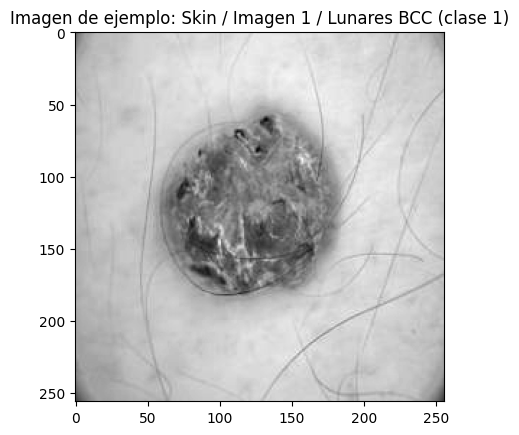

In [47]:
test_img = imageload(1,89)
plt.imshow(test_img, cmap='gray')
plt.title('Imagen de ejemplo: Skin / Imagen 1 / Lunares BCC (clase 1)')
plt.show()

### Preprocesamiento de imagenes

💬 Primero, preprocesaremos las imagenes para eliminar cierta informacion que deberiamos no extraer. Por ejemplo, los pelos, o manchas de la piel. Para asi, poder tener una mejor clasificacion enfocandonos solamente en la region del lunar.Para esto ocuparemos caracteristicas de intensidad basicas.


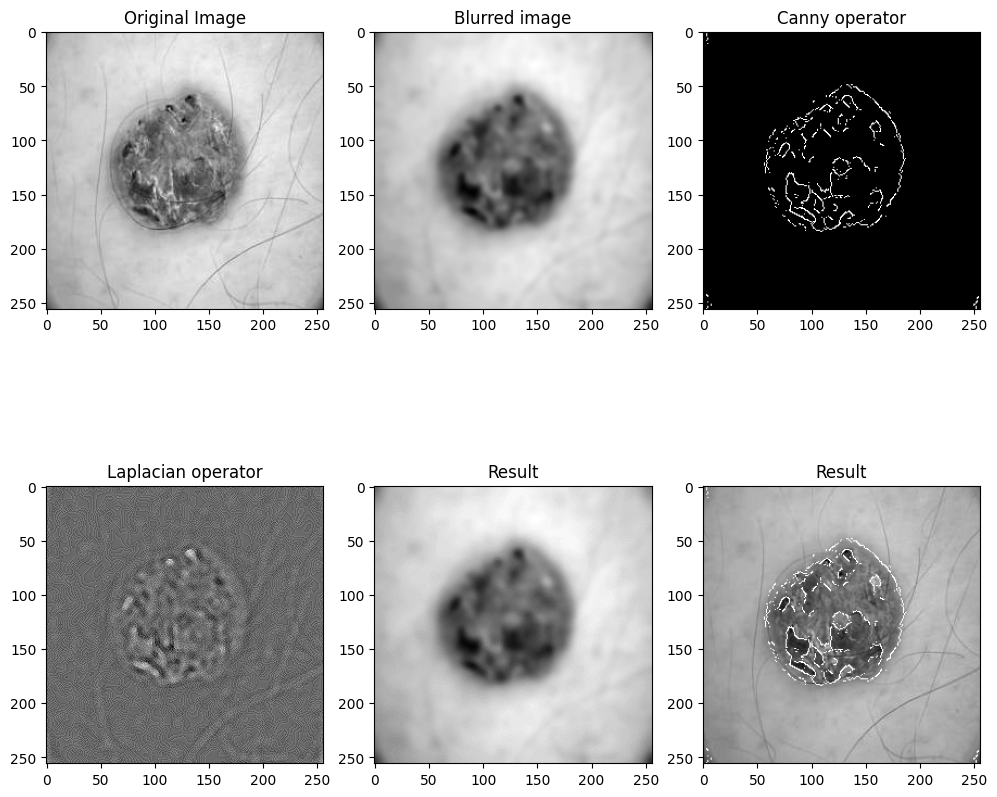

In [193]:
def blurring(img, blur_type):
    if blur_type == 'gaussian': # Gaussian blurring
        return cv2.GaussianBlur(img, (5,5), 0)
    elif blur_type == 'median': # Median blurring
        return cv2.medianBlur(img, 5)
    elif blur_type == 'bilateral': # Bilateral Filtering
        return cv2.bilateralFilter(img, 9, 75, 75)

def blur_image(img):
    img1 = blurring(img, 'median')
    img2 = blurring(img1, 'bilateral')

def remove_noise(img, show=False):
    # -- Median and Bilateral Blurring --
    # Removemos los pelos de la imagen aplicando
    # utilizando Gaussian y Median blurring.
    # img1 = blurring(img, 'median')
    img1 = blurring(img, 'median')
    img2 = blurring(img1, 'bilateral')

    # -- Canny Edge Detection --
    # SigmaColor = 100; SigmaSpace = 10
    img3 = cv2.Canny(img2, 35, 35) # Adaptamos al mejor threshold para obtener una buena segmentacion.

    # -- Laplacian operation --
    ddepth = cv2.CV_16S # 16-bit signed integers
    kernel_size = 3
    img4 = cv2.Laplacian(img2, ddepth, kernel_size)

    img2_converted = img2.astype(img4.dtype)

    # ---
    img_canny_multiplied = cv2.bitwise_or(img, img3)
    # -- Important information --
    alpha = 0.5
    beta = 1.0 - alpha
    dst = cv2.addWeighted(img4, alpha, img2_converted, beta, 0.0)





    if show:
        fig, axs = plt.subplots(2, 3, figsize=(10, 10))

        axs[0,0].imshow(img, cmap='gray')
        axs[0,0].set_title('Original Image')

        axs[0,1].imshow(img2, cmap='gray')
        axs[0,1].set_title('Blurred image')

        axs[0,2].imshow(img3, cmap='gray')
        axs[0,2].set_title('Canny operator')

        axs[1,0].imshow(img4, cmap='gray')
        axs[1,0].set_title('Laplacian operator')

        axs[1,1].imshow(dst, cmap='gray'),
        axs[1,1].set_title('Result')

        axs[1,2].imshow(img_canny_multiplied, cmap='gray'),
        axs[1,2].set_title('Result')

        plt.tight_layout()
        plt.show()
    return img3


test_img2 = imageload(1,89)
new_img = remove_noise(test_img2, show=True)



#plt.imshow(new_img, cmap='gray')
plt.show()



# 2. Feature Extraction

### Extracción de características

In [ ]:
K = 5 # Cantidad de clases del dataset
N = 240 # Cantidad de imagenes por clase
Y = np.zeros((K * N), 'int') # Vector de clasificacion


# ------------------------------- LBP ------------------------------------------
Mlbp = 59 # Numero de elementos vector LBP
Xlbp = np.zeros((K * N, Mlbp))
hdiv = 1 # LBP con 1x1 particiones
vdiv = 1
# Mlbp = 10 # Numero de elementos vector LBP invariante a la rotacion


# ----------------------------- HARALICK ---------------------------------------
Mhar1 = 24 # Numero de elmenentos vector Haralick para distancia = 3
Xhar1 = np.zeros((K * N, Mhar1))
d1 = 1 # Parametro de distancia

Mhar3 = 24 # Numero de elmenentos vector Haralick para distancia = 3
Xhar3 = np.zeros((K * N, Mhar3))
d3 = 3

Mhar5 = 24 # Numero de elmenentos vector Haralick para distancia = 5
Xhar5 = np.zeros((K * N, Mhar5))
d5 = 5


# ------------------------------- Hog ------------------------------------------
Mhog = 9 # Numero de elementos vector Hog usando solamente 9 bins
Xhog = np.zeros((K * N, Mhog))
hog_orientations = 9
hog_px = 256 # Parametro pixeles por bloque
hog_cl = 1 # Parametro celdas por blocque


# ------------------------------- Gabor ----------------------------------------
Mgab = 8*8+3 # Numero de elementos vector de Gabor para 8 rotaciones y escalas
Xgab = np.zeros((K * N, Mgab))
g_rotations = 8 # 8 rotaciones
g_dilations = 8 # 8 escalas


💬 `EXTRACTION_FLAG`: Para poder cargar los datos desde la nube, su valor debe ser 0. En otro caso, si queremos extraer las caracteristicas de cada imagen su valor debe ser 1.

In [ ]:
EXTRACTION_FLAG = 0

In [ ]:
t = 0
if EXTRACTION_FLAG:
    print('EXTRACTION_FLAG Activado: Extrayendo caracteristicas ...')
    for k in range(K): # Por cada clase ...
        print(f'Extrayendo caracteristicas: batch {k + 1}/5')
        for i in tqdm(range(N)): # Por cada imagen ...
            num_class = k + 1
            num_img = i + 1

            img = 255*imageload(num_class, num_img)

            # LBP con 1x1 particiones
            Xlbp[t,:] = lbp(img, hdiv=hdiv, vdiv=vdiv, mapping='nri_uniform')

            # Haralick con d=1 pixeles
            Xhar1[t,:] = haralick(img, distance=d1)
            # Haralick con d=3 pixeles
            Xhar3[t,:] = haralick(img, distance=d3)
            # Haralick con d=5 pixeles
            Xhar5[t,:] = haralick(img, distance=d5)

            # Hog con 9 orientaciones
            Xhog[t,:] = hog(img, orientations=hog_orientations,
                            cells_per_block=(hog_cl, hog_cl),
                            pixels_per_cell=(hog_px, hog_px), norm=False)
            # Gabor
            Xgab[t,:] = gabor(img, dilations=g_dilations, rotations=g_rotations)

            # Vector de clasificacion
            Y[t] = k # guardamos la clase en Y.
            t = t + 1

    # Guardamos las caracteristicas en la nube de archivos npy.
    np.save('lbp.npy', Xlbp)
    np.save('haralick1.npy', Xhar1)
    np.save('haralick3.npy', Xhar3)
    np.save('haralick5.npy', Xhar5)
    np.save('hog.npy', Xhog)
    np.save('gabor.npy', Xgab)

else:
    print('EXTRACTION_FLAG Desactivado: Extrayendo caracteristicas desde la nube ...')
    Xlbp = np.load('lbp.npy')
    Xhar1 = np.load('haralick1.npy')
    Xhar3 = np.load('haralick3.npy')
    Xhar5 = np.load('haralick5.npy')
    Xhog = np.load('hog.npy')
    Xgab = np.load('gabor.npy')

EXTRACTION_FLAG Desactivado: Extrayendo caracteristicas desde la nube ...


In [ ]:
X = np.concatenate((Xlbp, Xhar1, Xhar3, Xhar5, Xhog, Xgab), axis=1)
# X = np.concatenate((Xgab, Xhar3, Xhar5, Xhog), axis=1)
print('Total de caracteristicas: ', X.shape[1])

Total de caracteristicas:  207


# 3. Training and testing subsets

💬 Utilizaremos la funcion `SplitTrainTest` de las actividades E06 para separar los datos en training y testing.


In [ ]:
# Separación entre training y testing
# las primeras n muestras de X serán para el training, el resto
# para el testing
def SplitTrainTest(X,y,n):

  K      = np.max(y)+1              # número de clases
  N      = int(X.shape[0]/K)        # numeros de muestras por clase
  Ntrain = n*K                      # número de muestras para el training
  Ntest  = K*N-Ntrain               # número de muestras para el testing
  M      = X.shape[1]               # número de características por muestra
  Xtrain = np.zeros((Ntrain,M))     # subset de training
  ytrain = np.zeros((Ntrain),'int') # ground truth del training
  Xtest  = np.zeros((Ntest,M))      # subset de testing
  ytest  = np.zeros((Ntest),'int')  # ground truth del testing

  # contadores
  itrain = 0
  itest  = 0
  t      = 0

  for j in range(K):     # para cada clase
    for i in range(N):   # para cada imagen de la clase
      if i<n: # training
        Xtrain[itrain,:] = X[t,:]
        ytrain[itrain] = y[t]
        itrain = itrain+1
      else:  # testing
        Xtest[itest,:] = X[t,:]
        ytest[itest] = y[t]
        itest = itest+1
      t = t+1

  return Xtrain,ytrain,Xtest,ytest

In [ ]:
n_train = 200
Xtrain,Ytrain,Xtest,Ytest = SplitTrainTest(X, Y, n_train)


## Cleaning

In [ ]:
sclean = clean(Xtrain)  # Indices de las caracteristicas seleccionadas con el
                        # algoritmo clean.
Xtrain_clean = Xtrain[:,sclean] # Nuevo training.
Xtest_clean = Xtest[:,sclean] # Nuevo testing.
print(f'Cantidad de caracteristicas seleccionadas: {sclean.shape[0]}')


Cantidad de caracteristicas seleccionadas: 151


## Normalization

In [ ]:
Xtrain_norm, a, b = minmax(Xtrain_clean)
Xtest_norm = Xtest_clean * a + b

# 4. Classification

Primero seleccionaremos las mejores 30 caracteristicas utilizando el algoritmo SFS.


In [ ]:
p = 30
sfs_indices = sfs(Xtrain_norm, Ytrain, p)
print(sfs_indices)

[ 99 149  96  68  45 139  16 123  50  98  90  77  86 140  56  41  51  57
 131 108  30   5 141 112 150 107  87  94  63  28]


Con el arreglo de los indices de las columnas que presentan los mejores fischer scores seleccionaremos las columnas de Xtrain_norm y Xtest_norm.


In [ ]:
Xtrain_sfs = Xtrain_norm[:,sfs_indices]
Xtest_sfs = Xtest_norm[:,sfs_indices]

Utilizaremos la siguiente funcion `KNNClassifier` para poder clasificar los datos utilizando el algoritmo KNN.

In [ ]:
# Clasificación usando KNN con K vecinos
def KNNClassifier(Xtrain,ytrain,Xtest,K):
  # Normalizacion MinMax
  # Xtrain, a, b = minmax(Xtrain)
  # Xtest        = Xtest * a + b

  # Training
  knn = KNeighborsClassifier(n_neighbors=K)
  knn.fit(Xtrain, ytrain)
  print('Entrenando con '+str(Xtrain.shape[0])+' muestras y probando con '+str(Xtest.shape[0])+' muestras')

  # Testing
  ypred        = knn.predict(Xtest)
  return ypred


In [ ]:
def accuracy(ytrain, ytest, ypred):
  testing_acc  = accuracy_score(ytest, ypred)
  print(f'Testing Accuracy (AccTest) = {testing_acc}')

  return testing_acc
for n in [1, 3, 5]:
    print(f'Para K={n} vecinos')
    ypred = KNNClassifier(Xtrain_sfs,Ytrain,Xtest_sfs,n)
    accuracy(Ytrain, Ytest, ypred)
    print()

Para K=1 vecinos
Entrenando con 1000 muestras y probando con 200 muestras
Testing Accuracy (AccTest) = 0.39

Para K=3 vecinos
Entrenando con 1000 muestras y probando con 200 muestras
Testing Accuracy (AccTest) = 0.365

Para K=5 vecinos
Entrenando con 1000 muestras y probando con 200 muestras
Testing Accuracy (AccTest) = 0.375



In [ ]:
Ypred = KNNClassifier(Xtrain_sfs,Ytrain,Xtest_sfs, 1)

Entrenando con 1000 muestras y probando con 200 muestras


# 5. Evaluation

In [ ]:
def accuracy(ytrain, ytest, ypred):
  # Evaluacion desempeño
  testing_acc  = accuracy_score(ytest, ypred)
  #training_acc = accuracy_score(ytrain, ypred)
  #total_acc = 0.2 * training_acc + 0.8 * testing_acc
  print(f'Testing Accuracy (AccTest) = {testing_acc}')
  #print(f'Training Accuracy (AccTrain) = {training_acc}')
  #print(f'Total Accuracy (AccTot) = {total}')
  C = confusion_matrix(Ytest, ypred)

  return testing_acc, C


In [ ]:
testing_acc, C = accuracy(Ytrain, Ytest, Ypred)


Testing Accuracy (AccTest) = 0.39


<Axes: >

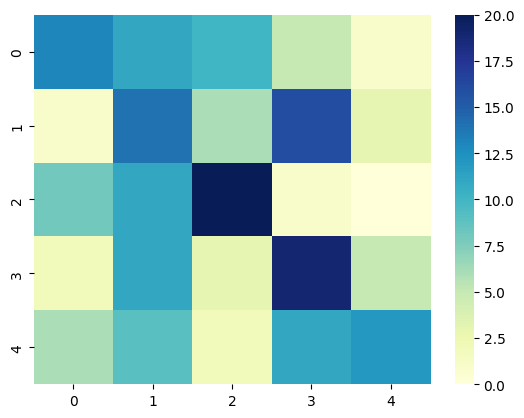

In [ ]:
heatmap(C, cmap='YlGnBu')